# Google drive mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 파일 가져오기

In [ ]:
cd /content

/content


In [2]:
!unzip /content/drive/MyDrive/rokey/rokey-boot-camp-mini-competition-2-week-2.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: Kaggle03/train/toy_poodle/113785.JPEG  
  inflating: Kaggle03/train/toy_poodle/113786.JPEG  
  inflating: Kaggle03/train/toy_poodle/113787.JPEG  
  inflating: Kaggle03/train/toy_poodle/113788.JPEG  
  inflating: Kaggle03/train/toy_poodle/113789.JPEG  
  inflating: Kaggle03/train/toy_poodle/113790.JPEG  
  inflating: Kaggle03/train/toy_poodle/113791.JPEG  
  inflating: Kaggle03/train/toy_poodle/113792.JPEG  
  inflating: Kaggle03/train/toy_poodle/113793.JPEG  
  inflating: Kaggle03/train/toy_poodle/113794.JPEG  
  inflating: Kaggle03/train/toy_poodle/113795.JPEG  
  inflating: Kaggle03/train/toy_poodle/113796.JPEG  
  inflating: Kaggle03/train/toy_poodle/113797.JPEG  
  inflating: Kaggle03/train/toy_poodle/113798.JPEG  
  inflating: Kaggle03/train/toy_poodle/113799.JPEG  
  inflating: Kaggle03/train/toy_poodle/113800.JPEG  
  inflating: Kaggle03/train/toy_poodle/113801.JPEG  
  inflating: Kaggle03/train/toy_poodle/113802.JPEG  
  inflatin

# 파일 구조 확인

In [ ]:
!ls Kaggle03/


name2id.json  test  train


In [ ]:
!ls Kaggle03/train

affenpinscher			EntleBucher		     Old_English_sheepdog
Afghan_hound			Eskimo_dog		     otterhound
Airedale			flat-coated_retriever	     papillon
American_Staffordshire_terrier	French_bulldog		     Pekinese
Appenzeller			German_shepherd		     Pembroke
Australian_terrier		German_short-haired_pointer  Pomeranian
basenji				giant_schnauzer		     pug
basset				golden_retriever	     redbone
beagle				Gordon_setter		     Rhodesian_ridgeback
Bedlington_terrier		Great_Dane		     Rottweiler
Bernese_mountain_dog		Greater_Swiss_Mountain_dog   Saint_Bernard
black-and-tan_coonhound		Great_Pyrenees		     Saluki
Blenheim_spaniel		groenendael		     Samoyed
bloodhound			Ibizan_hound		     schipperke
bluetick			Irish_setter		     Scotch_terrier
Border_collie			Irish_terrier		     Scottish_deerhound
Border_terrier			Irish_water_spaniel	     Sealyham_terrier
borzoi				Irish_wolfhound		     Shetland_sheepdog
Boston_bull			Italian_greyhound	     Shih-Tzu
Bouvier_des_Flandres		Japanese_spaniel	     Siberian_h

In [ ]:
!ls Kaggle03/test

000000.JPEG  000843.JPEG  001686.JPEG  002529.JPEG  003372.JPEG  004215.JPEG  005058.JPEG
000001.JPEG  000844.JPEG  001687.JPEG  002530.JPEG  003373.JPEG  004216.JPEG  005059.JPEG
000002.JPEG  000845.JPEG  001688.JPEG  002531.JPEG  003374.JPEG  004217.JPEG  005060.JPEG
000003.JPEG  000846.JPEG  001689.JPEG  002532.JPEG  003375.JPEG  004218.JPEG  005061.JPEG
000004.JPEG  000847.JPEG  001690.JPEG  002533.JPEG  003376.JPEG  004219.JPEG  005062.JPEG
000005.JPEG  000848.JPEG  001691.JPEG  002534.JPEG  003377.JPEG  004220.JPEG  005063.JPEG
000006.JPEG  000849.JPEG  001692.JPEG  002535.JPEG  003378.JPEG  004221.JPEG  005064.JPEG
000007.JPEG  000850.JPEG  001693.JPEG  002536.JPEG  003379.JPEG  004222.JPEG  005065.JPEG
000008.JPEG  000851.JPEG  001694.JPEG  002537.JPEG  003380.JPEG  004223.JPEG  005066.JPEG
000009.JPEG  000852.JPEG  001695.JPEG  002538.JPEG  003381.JPEG  004224.JPEG  005067.JPEG
000010.JPEG  000853.JPEG  001696.JPEG  002539.JPEG  003382.JPEG  004225.JPEG  005068.JPEG
000011.JPE

In [4]:
import json
import random
from glob import glob
from collections import defaultdict
from typing import Any, Callable, List, Optional, Type, Union

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split, Subset, WeightedRandomSampler
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from PIL import Image, ImageFilter
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from pprint import pprint


# DataLoader

압축푼 직후에는 파일적용이 되지 않아 FileNotFoundError 오류가 뜰 수 있습니다.

약간 대기 후 다시 실행하면 됩니다.

In [9]:

# 시드 설정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # 원하는 시드 값 입력

class MyDataset(Dataset):
    def __init__(self, data_path, transform=None, train=True):
        self.train = train
        self.transform = transform

        # JSON 파일에서 클래스 매핑 로드
        with open(f"{data_path}/name2id.json") as f:
            self.name2id = json.load(f)

        # 이미지 경로 설정
        if self.train:
            self.img_path = glob(f"{data_path}/train/*/*.JPEG")
            self.labels = [self.name2id[d.split("/")[-2]] for d in self.img_path]
        else:
            self.img_path = glob(f"{data_path}/test/*.JPEG")
            self.labels = None

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')
        img = self.transform(img) if self.transform else img

        if self.train:
            return img, self.labels[index]
        else:
            return img, self.img_path[index].split("/")[-1]


# 데이터 경로와 변환 설정
data_path = "./Kaggle03"
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색감 증강 추가
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화 추가
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색감 증강 추가
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화 추가
])

# train용 dataset과 validation용 dataset을 개별적으로 생성
train_dataset = MyDataset(data_path, train=True, transform=transform_train)
val_dataset = MyDataset(data_path, train=True, transform=transform_test)

# train/val split
train_indices, val_indices = train_test_split(
    list(range(len(train_dataset))),
    test_size=0.1,
    random_state=42,
    stratify=train_dataset.labels
)

# 훈련 데이터에 대한 클래스 가중치 계산
train_labels = [train_dataset.labels[i] for i in train_indices]
class_counts = np.bincount(train_labels)  # 각 클래스의 샘플 수를 계산
class_weights = 1.0 / class_counts  # 각 클래스의 가중치 계산
class_weights[np.isinf(class_weights)] = 0  # 가중치가 무한대인 경우 0으로 설정
sample_weights = class_weights[train_labels]  # 각 샘플의 가중치 할당

# WeightedRandomSampler 설정
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Subset을 사용하여 훈련 및 검증 데이터셋 생성
train_data = Subset(train_dataset, train_indices)
val_data = Subset(val_dataset, val_indices)
batch_size = 128
# train_loader와 val_loader 설정
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)

# 테스트 데이터셋 로드
test_data = MyDataset(data_path, train=False, transform=transform_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# 각 배치에서 클래스 분포 확인
for batch in train_loader:
    images, labels = batch
    batch_class_distribution = {label.item(): (labels == label).sum().item() for label in set(labels.numpy())}

    print("Batch Class Distribution:")
    pprint(batch_class_distribution)  # 가독성을 높여 출력
    break  # 첫 번째 배치만 확인


Batch Class Distribution:
{0: 1,
 3: 3,
 4: 1,
 5: 1,
 6: 1,
 8: 1,
 9: 1,
 10: 3,
 12: 2,
 13: 1,
 14: 1,
 16: 1,
 18: 1,
 19: 1,
 22: 1,
 24: 2,
 25: 1,
 26: 1,
 27: 1,
 28: 2,
 31: 1,
 32: 1,
 33: 1,
 34: 2,
 35: 2,
 36: 2,
 37: 2,
 38: 2,
 40: 1,
 41: 1,
 43: 2,
 44: 1,
 45: 1,
 47: 1,
 48: 1,
 49: 1,
 50: 2,
 51: 1,
 53: 2,
 54: 1,
 55: 2,
 56: 1,
 57: 2,
 58: 1,
 59: 1,
 60: 2,
 61: 2,
 64: 4,
 65: 1,
 66: 1,
 67: 2,
 68: 1,
 69: 2,
 72: 1,
 75: 1,
 76: 1,
 77: 1,
 78: 2,
 81: 6,
 83: 2,
 84: 1,
 85: 1,
 86: 2,
 89: 1,
 90: 2,
 91: 3,
 92: 2,
 93: 2,
 95: 1,
 96: 2,
 98: 1,
 100: 3,
 102: 1,
 104: 3,
 105: 1,
 106: 1,
 108: 1,
 109: 1,
 110: 2,
 111: 1,
 112: 4,
 117: 1}


In [10]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [11]:
import random
from collections import defaultdict
import matplotlib.pyplot as plt

# 각 라벨별로 num_samples 만큼 샘플을 수집하는 함수
def sample_images_by_label(dataloader, num_samples=10):
    sampled_images = defaultdict(list)
    for images, labels in dataloader:
        for img, label in zip(images, labels):
            label = label.item()
            if len(sampled_images[label]) < num_samples:
                sampled_images[label].append(img)
        # 각 라벨별로 num_samples 만큼 모이면 종료
        if all(len(sampled_images[label]) >= num_samples for label in sampled_images):
            break
    return sampled_images

# 각 라벨별로 10개의 이미지 샘플 수집
sampled_images = sample_images_by_label(train_loader, num_samples=10)

# 랜덤으로 5개의 라벨 선택
selected_labels = random.sample(list(sampled_images.keys()), 5)

# 선택된 라벨의 이미지 출력
for label_index, label in enumerate(selected_labels, start=1):
    images = sampled_images[label]
    print(f"Label {label} (출력 순서 {label_index}): {len(images)} images")
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2행 5열의 서브플롯 생성
    for i, (img, ax) in enumerate(zip(images, axes.flatten())):
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.axis('off')
    plt.tight_layout()
    plt.show()



Output hidden; open in https://colab.research.google.com to view.

Label 5 - Group 1: 5 images


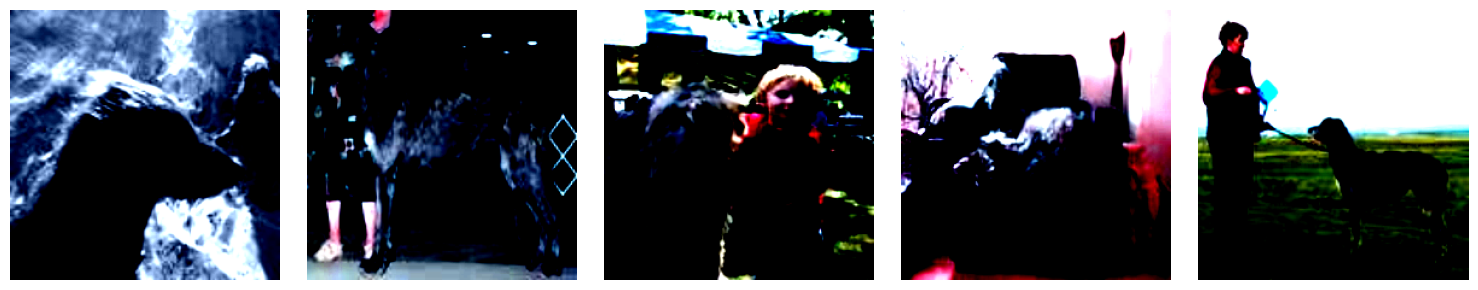

Label 5 - Group 2: 5 images


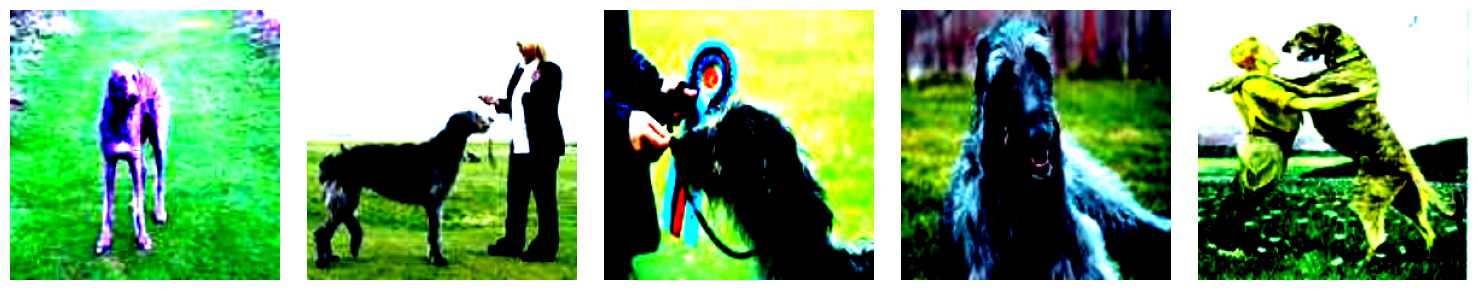

Label 5 - Group 3: 3 images


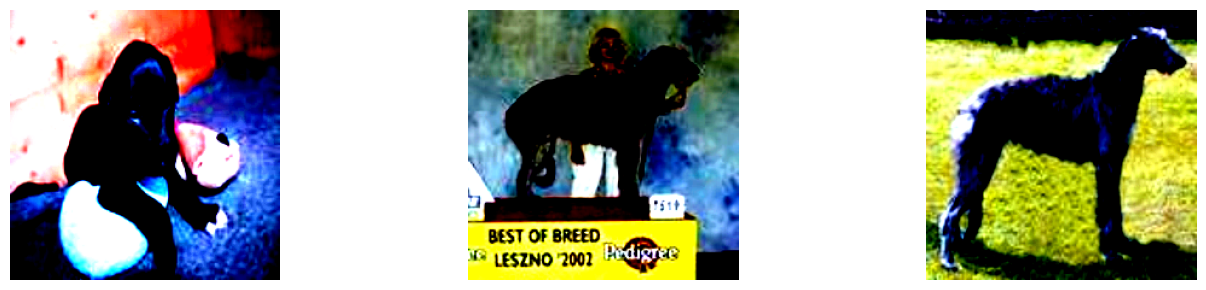

In [12]:
# n장을 뽑도록 설정
n = 13  # 원하는 장 수로 설정 가능
k = 5  # 선택한 라벨

# DataLoader에서 샘플링하여 선택한 라벨 k의 이미지 n개씩 출력
def sample_images_by_label(dataloader, label, num_samples):
    sampled_images = []
    for images, labels in dataloader:
        label_indices = (labels == label).nonzero(as_tuple=True)[0].tolist()  # 라벨 k의 인덱스 찾기
        if len(label_indices) > 0:
            sampled_indices = random.sample(label_indices, min(num_samples, len(label_indices)))  # n개의 인덱스 랜덤 선택
            sampled_images.extend([images[i] for i in sampled_indices])  # 선택한 인덱스의 이미지 가져오기
        if len(sampled_images) >= num_samples:
            break  # 원하는 수의 이미지를 수집하면 종료
    return sampled_images[:num_samples]

# 선택한 라벨 k의 이미지 n개 샘플링
images_to_display = sample_images_by_label(train_loader, k, n)

# 샘플링한 이미지 출력
num_groups = len(images_to_display) // 5 + (len(images_to_display) % 5 > 0)  # 5장씩 그룹 수 계산
for i in range(num_groups):
    group_images = images_to_display[i*5:(i+1)*5]  # 5장의 이미지를 그룹으로 선택
    print(f"Label {k} - Group {i+1}: {len(group_images)} images")

    fig, axes = plt.subplots(1, len(group_images), figsize=(15, 3))  # 1행 len(group_images)열의 서브플롯 생성
    for img, ax in zip(group_images, axes):
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
# JSON 파일 경로
file_path = 'Kaggle03/name2id.json'

# JSON 파일 읽기
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# 이쁘게 출력하기
print(json.dumps(data, indent=4, ensure_ascii=False))

{
    "Newfoundland": 0,
    "Great_Dane": 1,
    "Rhodesian_ridgeback": 2,
    "miniature_schnauzer": 3,
    "Chihuahua": 4,
    "Scottish_deerhound": 5,
    "Norwich_terrier": 6,
    "cairn": 7,
    "Mexican_hairless": 8,
    "Sussex_spaniel": 9,
    "papillon": 10,
    "basenji": 11,
    "German_short-haired_pointer": 12,
    "Shih-Tzu": 13,
    "Scotch_terrier": 14,
    "Lakeland_terrier": 15,
    "standard_schnauzer": 16,
    "Ibizan_hound": 17,
    "Japanese_spaniel": 18,
    "curly-coated_retriever": 19,
    "miniature_poodle": 20,
    "Eskimo_dog": 21,
    "American_Staffordshire_terrier": 22,
    "Leonberg": 23,
    "black-and-tan_coonhound": 24,
    "Irish_wolfhound": 25,
    "Appenzeller": 26,
    "malamute": 27,
    "Border_terrier": 28,
    "Australian_terrier": 29,
    "Afghan_hound": 30,
    "Samoyed": 31,
    "giant_schnauzer": 32,
    "Great_Pyrenees": 33,
    "Pembroke": 34,
    "chow": 35,
    "Bedlington_terrier": 36,
    "Rottweiler": 37,
    "Pomeranian": 38,
    

In [14]:
# 각 데이터셋의 변환을 출력
print("Train Transform:", train_data.dataset.transform)
# Validation 데이터셋에 대한 변환 확인
val_dataset_transform = val_data.dataset.transform  # Subset의 dataset 접근
print("Validation Transform:", val_dataset_transform)
# Test 데이터셋에 대한 변환 확인
print("Test Transform:", test_data.transform)

print("\nTrain Loader Attributes:", dir(train_loader),"\n")

# DataLoader에서 dataset 속성을 통해 변환 확인
print("Train Loader Transform:", train_loader.dataset.dataset.transform)  # Subset의 dataset 접근
print("Validation Loader Transform:", val_loader.dataset.dataset.transform)  # Subset의 dataset 접근
print("Test Loader Transform:", test_loader.dataset.transform)

# DataLoader 속성 확인


Train Transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Validation Transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Test Transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Train Loader Attributes: ['_DataLoader__initialized', '_DataLoader__multiprocessing_context', '_IterableDatase

In [15]:
print("총 학습 데이터 수",len(train_data))
print("총 val 데이터 수",len(val_data))
print("총 test 데이터 수",len(test_data))

print("배치 사이즈  ", batch_size)

print("배치시 총 학습 데이터 수",len(train_loader))
print("배치시 총 val 데이터 수",len(val_loader))
print("배치시 총 test 데이터 수",len(test_loader))

총 학습 데이터 수 133085
총 val 데이터 수 14788
총 test 데이터 수 5900
배치 사이즈   128
배치시 총 학습 데이터 수 1040
배치시 총 val 데이터 수 116
배치시 총 test 데이터 수 47


In [ ]:
from collections import defaultdict

# 라벨별 데이터 수를 저장할 딕셔너리 초기화
label_counts = defaultdict(int)
label_counts_val = defaultdict(int)

# 데이터 수
train_size = 1300 * 0.9
val_size = 1300 * 0.1

# train_loader에서 배치 단위로 데이터를 불러옴
for images, labels in train_loader:
    # 배치에 있는 모든 라벨을 카운트
    for label in labels:
        label_counts[label.item()] += 1

# 라벨별 데이터 수 출력
print("Train Label Counts:")
for label, count in sorted(label_counts.items()):
    print(f"Label {label}: {count} samples, Difference from expected: {count - train_size / len(label_counts)}")

print("-" * 100)



Train Label Counts:
Label 0: 1094 samples, Difference from expected: 1084.084745762712
Label 1: 1111 samples, Difference from expected: 1101.084745762712
Label 2: 1102 samples, Difference from expected: 1092.084745762712
Label 3: 1117 samples, Difference from expected: 1107.084745762712
Label 4: 1136 samples, Difference from expected: 1126.084745762712
Label 5: 1143 samples, Difference from expected: 1133.084745762712
Label 6: 1192 samples, Difference from expected: 1182.084745762712
Label 7: 1136 samples, Difference from expected: 1126.084745762712
Label 8: 1225 samples, Difference from expected: 1215.084745762712
Label 9: 1059 samples, Difference from expected: 1049.084745762712
Label 10: 1079 samples, Difference from expected: 1069.084745762712
Label 11: 1088 samples, Difference from expected: 1078.084745762712
Label 12: 1134 samples, Difference from expected: 1124.084745762712
Label 13: 1084 samples, Difference from expected: 1074.084745762712
Label 14: 1143 samples, Difference fro

In [ ]:
# val_loader에서 배치 단위로 데이터를 불러옴
for images, labels in val_loader:
    # 배치에 있는 모든 라벨을 카운트
    for label in labels:
        label_counts_val[label.item()] += 1

# 라벨별 데이터 수 출력 (검증 데이터)
print("Validation Label Counts:")
for label, count in sorted(label_counts_val.items()):
    print(f"Label {label}: {count} samples, Difference from expected: {count - val_size / len(label_counts_val)}")

Validation Label Counts:
Label 0: 130 samples, Difference from expected: 128.89830508474577
Label 1: 130 samples, Difference from expected: 128.89830508474577
Label 2: 130 samples, Difference from expected: 128.89830508474577
Label 3: 130 samples, Difference from expected: 128.89830508474577
Label 4: 130 samples, Difference from expected: 128.89830508474577
Label 5: 130 samples, Difference from expected: 128.89830508474577
Label 6: 130 samples, Difference from expected: 128.89830508474577
Label 7: 130 samples, Difference from expected: 128.89830508474577
Label 8: 75 samples, Difference from expected: 73.89830508474576
Label 9: 130 samples, Difference from expected: 128.89830508474577
Label 10: 130 samples, Difference from expected: 128.89830508474577
Label 11: 130 samples, Difference from expected: 128.89830508474577
Label 12: 130 samples, Difference from expected: 128.89830508474577
Label 13: 130 samples, Difference from expected: 128.89830508474577
Label 14: 130 samples, Difference f

In [ ]:
import warnings
import matplotlib.pyplot as plt

bad_list = [11, 13, 19, 10]
bad_words = ['tool', 'electronic', 'fumiture', 'container']
bad_dict = dict(zip(bad_list, bad_words))

good_list = [18, 6, 8, 16]
good_words = ['GeologicalFormation', 'Building', 'Food', 'Mammal']
good_dict = dict(zip(good_list, good_words))

In [ ]:
# 이선우 전처리
import warnings
import matplotlib.pyplot as plt

# 모든 경고 무시
warnings.filterwarnings("ignore")

# 이미지 시각화 함수
def display_images(image_list, title, label_dict, num_images=40, width=5):
    rows = (num_images + width - 1) // width  # 필요한 행 수 계산
    fig, axes = plt.subplots(rows, width, figsize=(15, 3 * rows))  # 행 수에 따라 크기 조정
    fig.suptitle(title)

    # 필요한 개수만큼 이미지 출력
    for i, (img, label) in enumerate(image_list[:num_images]):
        ax = axes[i // width, i % width]  # 위치 계산

        # 이미지 데이터 클리핑 (0-1 범위)
        img = img.clamp(0, 1)  # 0과 1 사이로 클리핑 (0-1 범위로 정규화된 경우)
        # 또는
        # img = img.clip(0, 255)  # 0-255 범위로 클리핑 (정수형 데이터의 경우)

        ax.imshow(img.permute(1, 2, 0))  # (C, H, W) -> (H, W, C) 형식으로 변경
        ax.axis('off')
        ax.set_title(label_dict[label])  # 딕셔너리에서 라벨에 해당하는 단어 가져오기

    # 남은 서브플롯은 비워두기
    for j in range(i + 1, rows * width):
        ax = axes[j // width, j % width]
        ax.axis('off')

    plt.show()

# 조건에 맞는 이미지 필터링 함수 (랜덤 시작점 및 순환 방식)
def filter_images_by_label(dataset, label_list, num_images):
    filtered_images = []
    count_per_label = {label: 0 for label in label_list}
    remaining_labels = set(label_list)

    # 무작위 시작점 선택
    start_index = random.randint(0, len(dataset) - 1)
    dataset_size = len(dataset)

    # 데이터셋을 시작 인덱스부터 순환
    idx = start_index
    while remaining_labels:
        img, label = dataset[idx]

        # 라벨이 label_list에 있고, 아직 num_images에 도달하지 않았다면 추가
        if label in remaining_labels:
            if count_per_label[label] < num_images:
                filtered_images.append((img, label))
                count_per_label[label] += 1

            # 해당 라벨이 충분한 이미지 수를 얻었으면 제거
            if count_per_label[label] >= num_images:
                remaining_labels.remove(label)

        # 인덱스 증가, 끝에 도달하면 처음으로 돌아감
        idx = (idx + 1) % dataset_size

    return filtered_images
number = 14
width = 7
# good과 bad 리스트에 따라 이미지 필터링
good_images = filter_images_by_label(train_data, good_list, number)
bad_images = filter_images_by_label(train_data, bad_list, number)

# good 이미지 내에서 라벨 기준으로 정렬
good_images_sorted = sorted(good_images, key=lambda x: x[1])  # 라벨 기준으로 정렬

# bad 이미지 내에서 라벨 기준으로 정렬
bad_images_sorted = sorted(bad_images, key=lambda x: x[1])  # 라벨 기준으로 정렬

# good과 bad 이미지 출력
display_images(good_images_sorted, "Good Images", good_dict, num_images=4 * number, width=width)  # 넓이 5
print("-" * 100)
display_images(bad_images_sorted, "Bad Images", bad_dict, num_images=4 * number, width=width)  # 넓이 5
